# **Model Training**

In [70]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
import joblib
import warnings
warnings.filterwarnings('ignore')

In [60]:
df = pd.read_csv('../data/cleaned/final.csv')
df.head()

,gender,SeniorCitizen,Marital_Status,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Married,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-19
1,Male,0,Single,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,20-39
2,Male,0,Single,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-19
3,Male,0,Single,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,40-59
4,Female,0,Single,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0-19


In [61]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [62]:
le = LabelEncoder()

X_encoded = pd.get_dummies(X)
y_encoded = le.fit_transform(y)

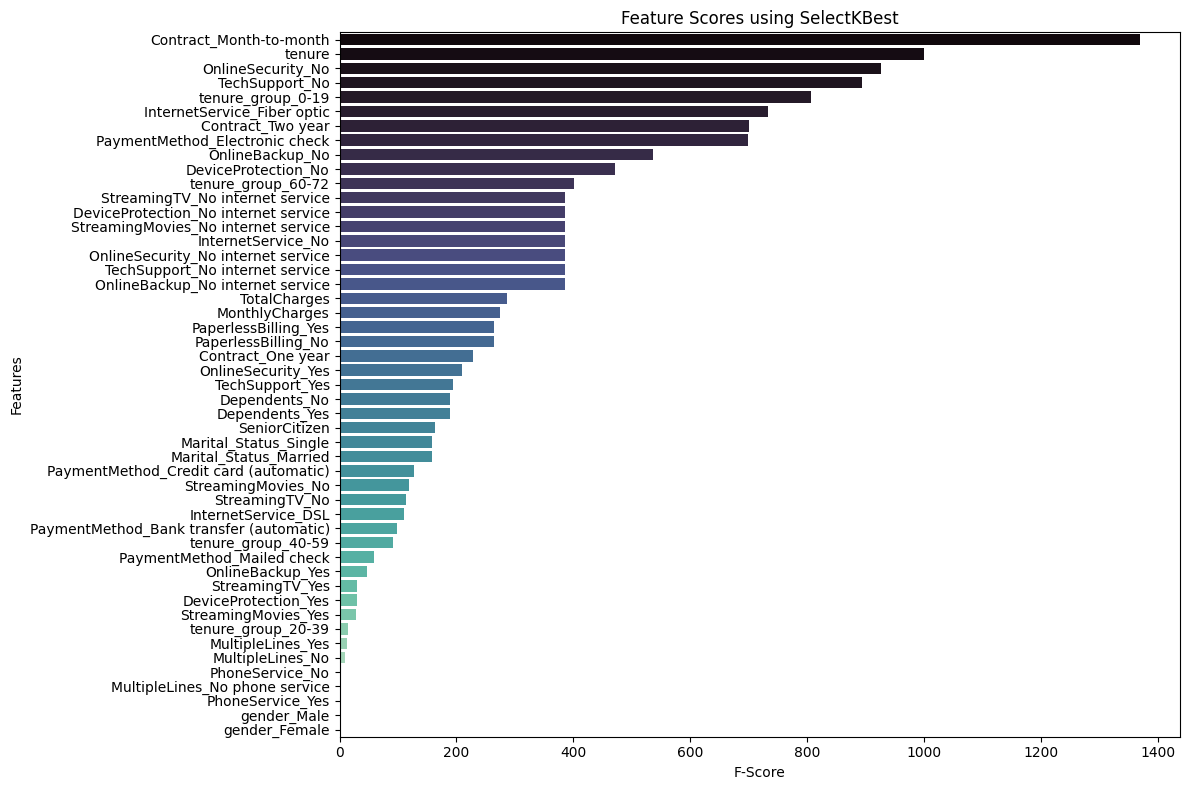

In [63]:
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_encoded, y_encoded)

feature_scores = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Score': selector.scores_
})

# Sort if you want (optional)
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

# Plot all scores
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores, palette='mako')
plt.title('Feature Scores using SelectKBest')
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [64]:
final_df = df[['tenure','tenure_group','Contract','InternetService','PaymentMethod','MonthlyCharges','TotalCharges','OnlineBackup','Churn']]
final_df.head()

,tenure,tenure_group,Contract,InternetService,PaymentMethod,MonthlyCharges,TotalCharges,OnlineBackup,Churn
0,1,0-19,Month-to-month,DSL,Electronic check,29.85,29.85,Yes,No
1,34,20-39,One year,DSL,Mailed check,56.95,1889.50,No,No
2,2,0-19,Month-to-month,DSL,Mailed check,53.85,108.15,Yes,Yes
3,45,40-59,One year,DSL,Bank transfer (automatic),42.30,1840.75,No,No
4,2,0-19,Month-to-month,Fiber optic,Electronic check,70.70,151.65,No,Yes


In [65]:
X = final_df.drop('Churn', axis=1)
y = final_df['Churn']

In [66]:
le = LabelEncoder()
X_encoded = pd.get_dummies(X, drop_first=True)
y_encoded = le.fit_transform(y)

In [67]:
X_train, X_test, y_train, y_test =  train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

In [11]:
print(f'Label 1: {sum(y_train == 1)}')
print(f'Label 0: {sum(y_train == 0)}')

Label 1: 1536
Label 0: 4072


In [12]:
sm = SMOTE(sampling_strategy=0.8, random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train.ravel())

In [13]:
print(f'Label 1: {sum(y_train_sm == 1)}')
print(f'Label 0: {sum(y_train_sm == 0)}')

Label 1: 3257
Label 0: 4072


In [14]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train_sm)
X_test_sc = sc.transform(X_test)

#### KNN

In [15]:
K = []
training = []
test = []
scores = {}

for k in range(2, 31):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train_sc, y_train_sm)

    training_score = clf.score(X_train_sc, y_train_sm)
    test_score = clf.score(X_test_sc, y_test)
    K.append(k)

    training.append(training_score)
    test.append(test_score)
    scores[k] = [training_score, test_score]

In [16]:
for keys, values in scores.items():
    print(keys, ':', values)

2 : [0.8890708145722472, 0.7703281027104137]
3 : [0.882930822758903, 0.7639087018544936]
4 : [0.8585072997680447, 0.7738944365192582]
5 : [0.8525037522172193, 0.7589158345221113]
6 : [0.8403602128530495, 0.7796005706134094]
7 : [0.8376313276026743, 0.7667617689015692]
8 : [0.8284895620139173, 0.7817403708987162]
9 : [0.8276708964388048, 0.7703281027104137]
10 : [0.8220766816755355, 0.7817403708987162]
11 : [0.8216673488879792, 0.7624821683309557]
12 : [0.8196206849501978, 0.7803138373751783]
13 : [0.8190749079001228, 0.7674750356633381]
14 : [0.8138900259244098, 0.7910128388017118]
15 : [0.812116250511666, 0.7796005706134094]
16 : [0.8095238095238095, 0.7881597717546363]
17 : [0.8088415882112158, 0.7746077032810271]
18 : [0.8070678127984718, 0.7881597717546363]
19 : [0.8078864783735844, 0.7767475035663338]
20 : [0.8047482603356528, 0.782453637660485]
21 : [0.8028380406603902, 0.7796005706134094]
22 : [0.8002455996725337, 0.7831669044222539]
23 : [0.8002455996725337, 0.7774607703281027]

In [17]:
model_knn = KNeighborsClassifier(n_neighbors=14)
model_knn.fit(X_train_sc, y_train_sm)

KNeighborsClassifier(n_neighbors=14)

In [18]:
def evaluate(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)
    print(cm)
    print(cr)

In [19]:
y_pred_knn = model_knn.predict(X_test_sc)

In [20]:
evaluate(y_test, y_pred_knn)

[[903 178]
 [115 206]]
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1081
           1       0.54      0.64      0.58       321

    accuracy                           0.79      1402
   macro avg       0.71      0.74      0.72      1402
weighted avg       0.81      0.79      0.80      1402



#### RandomForest

In [50]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_sc, y_train_sm)
y_pred_rf = model_rf.predict(X_test_sc)
evaluate(y_test, y_pred_rf)

[[905 176]
 [124 197]]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1081
           1       0.53      0.61      0.57       321

    accuracy                           0.79      1402
   macro avg       0.70      0.73      0.71      1402
weighted avg       0.80      0.79      0.79      1402



#### SVM

In [22]:
model_svm = SVC(kernel='linear')
model_svm.fit(X_train_sc, y_train_sm)
y_pred_svm = model_svm.predict(X_test_sc)
evaluate(y_test, y_pred_svm)

[[861 220]
 [ 98 223]]
              precision    recall  f1-score   support

           0       0.90      0.80      0.84      1081
           1       0.50      0.69      0.58       321

    accuracy                           0.77      1402
   macro avg       0.70      0.75      0.71      1402
weighted avg       0.81      0.77      0.78      1402



In [23]:
model_xg = XGBClassifier()
model_xg.fit(X_train_sc, y_train_sm)
y_pred_xg = model_xg.predict(X_test_sc)
evaluate(y_test, y_pred_xg)

[[886 195]
 [119 202]]
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1081
           1       0.51      0.63      0.56       321

    accuracy                           0.78      1402
   macro avg       0.70      0.72      0.71      1402
weighted avg       0.80      0.78      0.78      1402



In [24]:
model_ada = AdaBoostClassifier()
model_ada.fit(X_train_sc, y_train_sm)
y_pred_ada = model_xg.predict(X_test_sc)
evaluate(y_test, y_pred_ada)

[[886 195]
 [119 202]]
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1081
           1       0.51      0.63      0.56       321

    accuracy                           0.78      1402
   macro avg       0.70      0.72      0.71      1402
weighted avg       0.80      0.78      0.78      1402



### HPO

In [64]:
param_grid = {
    'n_estimators':[100,300],
    'max_depth':[3,7],
    'learning_rate':[0.05,0.1],
    'subsample':[0.7,1.0],
    'colsample_bytree':[0.7,1.0],
    'gamma': [0,0.1],
    'alpha': [1,2],
    'lambda':[0,1]
}

In [67]:
xgb_model = XGBClassifier()

grid_search = GridSearchCV(param_grid=param_grid, estimator=xgb_model, cv=3, verbose=1, scoring='accuracy')

grid_search.fit(X_train_sc, y_train_sm)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'alpha': [1, 2], 'colsample_bytree': [0.7, 1.0],
                         'gamma': [0, 0.1], 'lambda': [0, 1],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 7],
                         'n_estimators': [100, 300], 'subsample': [0.7, 1.0]},
             scoring='accuracy', verbose=1)

In [69]:
grid_search.best_params_

{'alpha': 1,
 'colsample_bytree': 1.0,
 'gamma': 0.1,
 'lambda': 0,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 100,
 'subsample': 1.0}

In [70]:
grid_search.best_score_

np.float64(0.8014735980352027)

In [71]:
grid_search.best_estimator_

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100, ...)

In [25]:
xgb_best = XGBClassifier(alpha = 1, n_estimaors = 200,colsample_bytree=1.0,gamma=0.1,learning_rate=0.05,max_depth=7, subsample=1.0)
xgb_best.fit(X_train_sc, y_train_sm)
y_pred_xgb_best = xgb_best.predict(X_test_sc)
evaluate(y_test, y_pred_xgb_best)

[[883 198]
 [112 209]]
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1081
           1       0.51      0.65      0.57       321

    accuracy                           0.78      1402
   macro avg       0.70      0.73      0.71      1402
weighted avg       0.80      0.78      0.79      1402



In [55]:
model_svm_best = SVC(kernel='rbf',class_weight='balanced')
model_svm_best.fit(X_train_sc, y_train_sm)
y_pred_svm_best = model_svm_best.predict(X_test_sc)
evaluate(y_test, y_pred_svm_best)

[[858 223]
 [ 88 233]]
              precision    recall  f1-score   support

           0       0.91      0.79      0.85      1081
           1       0.51      0.73      0.60       321

    accuracy                           0.78      1402
   macro avg       0.71      0.76      0.72      1402
weighted avg       0.82      0.78      0.79      1402



In [40]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
			'kernel': ['rbf']} 

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
 
grid.fit(X_train_sc, y_train_sm)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.749 total time=   0.4s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.745 total time=   0.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.749 total time=   0.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.725 total time=   0.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.754 total time=   0.4s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.756 total time=   0.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.761 total time=   0.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.799 total time=   0.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.757 total time=   0.3s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [41]:
grid.best_score_

np.float64(0.792064683450591)

In [ ]:
grid.best_params_

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

In [46]:
model_svm_best = SVC(kernel='rbf',C=100, gamma=0.1, class_weight='balanced')
model_svm_best.fit(X_train_sc, y_train_sm)
y_pred_svm_best = model_svm_best.predict(X_test_sc)
evaluate(y_test, y_pred_svm_best)

[[812 269]
 [ 80 241]]
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1081
           1       0.47      0.75      0.58       321

    accuracy                           0.75      1402
   macro avg       0.69      0.75      0.70      1402
weighted avg       0.81      0.75      0.77      1402



In [49]:
model_svm_best = SVC(kernel='rbf',class_weight='balanced')
model_svm_best.fit(X_train_sc, y_train_sm)
y_pred_svm_best = model_svm_best.predict(X_test_sc)
evaluate(y_test, y_pred_svm_best)

[[858 223]
 [ 88 233]]
              precision    recall  f1-score   support

           0       0.91      0.79      0.85      1081
           1       0.51      0.73      0.60       321

    accuracy                           0.78      1402
   macro avg       0.71      0.76      0.72      1402
weighted avg       0.82      0.78      0.79      1402



In [54]:
model_rf = RandomForestClassifier(random_state=42, n_estimators=400, max_depth=20)
model_rf.fit(X_train_sc, y_train_sm)
y_pred_rf = model_rf.predict(X_test_sc)
evaluate(y_test, y_pred_rf)

[[893 188]
 [122 199]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1081
           1       0.51      0.62      0.56       321

    accuracy                           0.78      1402
   macro avg       0.70      0.72      0.71      1402
weighted avg       0.80      0.78      0.79      1402



In [ ]:
numerical_features = ['tenure','MonthlyCharges','TotalCharges']
categorical_features = ['tenure_group','Contract','InternetService','PaymentMethod','OnlineBackup']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

smote_instance = SMOTE(random_state=42)
svm_model = SVC(kernel='rbf', class_weight='balanced')
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote_instance),
    ('classifier', svm_model)
])

model_filename = '../data/churn_prediction_pipeline.joblib'
pipeline.fit(final_df.drop('Churn', axis=1),final_df['Churn'])
joblib.dump(pipeline, model_filename)
print(f"Model pipeline successfully exported to '{model_filename}'")

Model pipeline successfully exported to '../data/churn_prediction_pipeline.joblib'


In [87]:
new_customer_data = pd.DataFrame({
    'tenure': [24],                          # Example: 24 months
    'MonthlyCharges': [75.50],               # Example: $75.50 per month
    'TotalCharges': [1800.00],               # Example: $1800 total charges
    'tenure_group': ['60-72'],               # Example: Tenure group 12-24 months
    'Contract': ['Month-to-month'],         # Example: Month-to-month contract
    'InternetService': ['Fiber optic'],      # Example: Fiber optic internet
    'PaymentMethod': ['Electronic check'],   # Example: Electronic check payment
    'OnlineBackup': ['Yes']                  # Example: Has online backup
})

In [88]:
pipeline.predict(new_customer_data)


array(['Yes'], dtype=object)